#### Project guidelines (comment to be removed)

https://github.com/suneman/socialdataanalysis2020/wiki/Final-Project


# Motivation.
merging Copenhagen traffic data with weather data to check if traffic volumes can be predicted over time and space


### What is your dataset?
* This dataset contains hourly data about some of the busiest roads in Copenhagen that is available from this oppen data page: 
https://www.opendata.dk/city-of-copenhagen/faste-trafiktaellinger#resource-faste_trafikt%C3%A6llinger_2008.xlsx


* The data reported are the total number of vehicles observed on these roads on each hour for all calendar days on each of the relevant roads


* Then for the weather we gathered data from.....


### Why did you choose this/these particular dataset(s)?
We thought it could be interesting to invesigate patterns in the data and try to forecast traffic volumes when we add weather data

### What was your goal for the end user's experience?
Building a tool that allows users to easily visualize the data in space and time and understand how thes traffic volumes/flows distribute across different timeframes, spaces/neighboroughs and weather conditions




# Basic stats. Let's understand the dataset better


### Write about your choices in data cleaning and preprocessing
We have deleted all the empty and oterwise irrelavant columns of data
Then we created new features, mostly time references that we will need to visualize the data by different time references: daily, weekly, yearly, etc.




In [1]:
import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utm
import folium

Downloading data and removing/adding features

In [2]:
# Downloading faste-trafiktaellinger-2008_clean (to be changed if we get data directly form website)
df = pd.read_csv("C:/Users/User/Dropbox/DTU/02806 Social data analysis and visualization/cph_traffic_2005-2014_original.csv",
                 parse_dates = ['Dato'],encoding='ISO-8859-1')

# cleaning Vej-Id for more clear traffic directions
df['Vej-Id'] = df['Vej-Id'].str.split(n=4).str[-1]

#change the Hours headers
for i in range(7,31):
    df = df.rename(columns={df.columns[i]: df.columns[i].split('.')[1].split('-')[0]})
    df[df.columns[i]] = df[df.columns[i]].str.replace(',', '').fillna(0).astype('float')

### converting UTM coordinates into Latitute/Longitude using the "utm" library: https://pypi.org/project/utm/
# first we create a function that applies the utm api to 2 Series of data
def uf(x):
    return utm.to_latlon(x[0], x[1], 32, 'T')
# then we apply this function to the UTM coordinates in the file
#df['LatLon'] = df[['Easting','Northing']].apply(uf, axis=1)
df[['Lat', 'Lon']] = pd.DataFrame(df[['(UTM32)','(UTM32).1']].apply(uf, axis=1).tolist(), index=df.index)

# removing the unwanted columns
df = df.drop(columns = ['Unnamed: 0','Spor','(UTM32)','(UTM32).1'])

# converting hours data columns into rows
df = df.melt(id_vars=["Vej-Id","Vejnavn","Dato","Lat","Lon"],
        value_vars=['00','01','02','03','04','05','06','07','08','09','10','11','12',
                    '13', '14','15', '16','17', '18','19','20','21','22','23'],
        var_name="Hour", 
        value_name="Vehicles")

### moving rows data for Vehicles Entering the City, Leaving the City and Net Traffic Flows into columns
# Selecting only Entering Vehicles (and creating a unique index)
df_ent = df[df['Vej-Id'] == '-']
df_ent['index'] = df_ent['Vejnavn'] + df_ent['Dato'].dt.strftime('%Y-%m-%d') + df_ent['Hour']
df_ent = df_ent.set_index('index')
# Selecting only Leaving Vehicles (and creating a unique index)
df_ex = df[df['Vej-Id'] == '+']
df_ex['index'] = df_ex['Vejnavn'] + df_ex['Dato'].dt.strftime('%Y-%m-%d') + df_ex['Hour']
df_ex = df_ex.set_index('index')
# Selecting only Total Vehicles on the roads (and creating a unique index)
df = df[df['Vej-Id'] == 'T']
df['index'] = df['Vejnavn'] + df['Dato'].dt.strftime('%Y-%m-%d') + df['Hour']
df = df.set_index('index')
# adding columns for Vehicles Entering the City, Leaving and Net Traffic Flows
df['Entering Vehicles'] = df_ent['Vehicles']
df['Leaving Vehicles'] = df_ex['Vehicles']
df['Net Traffic Flow'] = df['Entering Vehicles'] - df['Leaving Vehicles']
# renaming the Total Vehicles column
df = df.rename(columns={"Vehicles": "Total Vehicles"})

# randomizing Latitude and longitude points
mu, sigma1 = 0, 0.0015
mu, sigma2 = 0, 0.003
noise1 = np.random.normal(mu, sigma1, [len(df),1])
noise2 = np.random.normal(mu, sigma2, [len(df),1]) 
df[['Lat_rand']] = df[['Lat']] + noise1
df[['Lon_rand']] = df[['Lon']] + noise2

# Add Day of the Week, Day, ,Week, Month, Year,
df["DayName"] = df['Dato'].apply(lambda x: x.day_name())
df["WeekDay"] = df['Dato'].dt.weekday
df["DayOfMonth"] = df['Dato'].dt.day
df["Week"] = df['Dato'].dt.week
df["Month"] = df['Dato'].dt.month
df["Year"] = df['Dato'].dt.year

# removing the 'Vej-Id' columns to avoid confusion (now all traffic data are in the columns for "-" , "+" and "T")
df = df.drop(columns = ['Vej-Id'])

df.head(10)

<ipython-input-2-39c599446eb0>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ent['index'] = df_ent['Vejnavn'] + df_ent['Dato'].dt.strftime('%Y-%m-%d') + df_ent['Hour']
<ipython-input-2-39c599446eb0>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ex['index'] = df_ex['Vejnavn'] + df_ex['Dato'].dt.strftime('%Y-%m-%d') + df_ex['Hour']
<ipython-input-2-39c599446eb0>:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df

Vejnavn       Dato        Lat        Lon Hour  \
index                                                                          
Ellebjergvej2005-01-0400  Ellebjergvej 2005-01-04  55.650543  12.510778   00   
Ellebjergvej2005-02-0400  Ellebjergvej 2005-02-04  55.650543  12.510778   00   
Ellebjergvej2005-03-0400  Ellebjergvej 2005-03-04  55.650543  12.510778   00   
Ellebjergvej2005-04-0400  Ellebjergvej 2005-04-04  55.650543  12.510778   00   
Ellebjergvej2005-05-0400  Ellebjergvej 2005-05-04  55.650543  12.510778   00   
Ellebjergvej2005-06-0400  Ellebjergvej 2005-06-04  55.650543  12.510778   00   
Ellebjergvej2005-07-0400  Ellebjergvej 2005-07-04  55.650543  12.510778   00   
Ellebjergvej2005-08-0400  Ellebjergvej 2005-08-04  55.650543  12.510778   00   
Ellebjergvej2005-09-0400  Ellebjergvej 2005-09-04  55.650543  12.510778   00   
Ellebjergvej2005-10-0400  Ellebjergvej 2005-10-04  55.650543  12.510778   00   

                          Total Vehicles  Entering Vehicles  Leaving Vehicles  \
index                                                                           
Ellebjergvej2005-01-0400           191.0               83.0             108.0   
Ellebjergvej2005-02-0400           381.0              153.0             228.0   
Ellebjergvej2005-03-0400           457.0              182.0             275.0   
Ellebjergvej2005-04-0400           140.0               57.0              83.0   
Ellebjergvej2005-05-0400           159.0               73.0              86.0   
Ellebjergvej2005-06-0400           173.0               75.0              98.0   
Ellebjergvej2005-07-0400           190.0               68.0             122.0   
Ellebjergvej2005-08-0400           211.0               86.0             125.0   
Ellebjergvej2005-09-0400           366.0              142.0             224.0   
Ellebjergvej2005-10-0400           445.0              195.0             250.0   

                          Net Traffic Flow   Lat_rand   Lon_rand    DayName  \
index                                                                         
Ellebjergvej2005-01-0400             -25.0  55.648976  12.511375    Tuesday   
Ellebjergvej2005-02-0400             -75.0  55.652526  12.510882     Friday   
Ellebjergvej2005-03-0400             -93.0  55.650351  12.512223     Friday   
Ellebjergvej2005-04-0400             -26.0  55.647686  12.513367     Monday   
Ellebjergvej2005-05-0400             -13.0  55.649892  12.510263  Wednesday   
Ellebjergvej2005-06-0400             -23.0  55.650757  12.512035   Saturday   
Ellebjergvej2005-07-0400             -54.0  55.653714  12.511931     Monday   
Ellebjergvej2005-08-0400             -39.0  55.649636  12.514216   Thursday   
Ellebjergvej2005-09-0400             -82.0  55.649874  12.507173     Sunday   
Ellebjergvej2005-10-0400             -55.0  55.649239  12.511155    Tuesday   

                          WeekDay  DayOfMonth  Week  Month  Year  
index                                                             
Ellebjergvej2005-01-0400        1           4     1      1  2005  
Ellebjergvej2005-02-0400        4           4     5      2  2005  
Ellebjergvej2005-03-0400        4           4     9      3  2005  
Ellebjergvej2005-04-0400        0           4    14      4  2005  
Ellebjergvej2005-05-0400        2           4    18      5  2005  
Ellebjergvej2005-06-0400        5           4    22      6  2005  
Ellebjergvej2005-07-0400        0           4    27      7  2005  
Ellebjergvej2005-08-0400        3           4    31      8  2005  
Ellebjergvej2005-09-0400        6           4    35      9  2005  
Ellebjergvej2005-10-0400        1           4    40     10  2005

### Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.


Below is the Total Count of vehicles per Road in descending order recorded in the whole period and a barplot that allows the visualization of the data.
From both the list and the plot below you can see how there are significant differences in traffic volumes among the roads chosen in the dataset

In [3]:
totcount = df.groupby('Vejnavn')['Total Vehicles'].sum().sort_values(ascending=False)
pd.DataFrame(totcount.values, index = list(totcount.index), columns =['Total Vehicles']) 

Total Vehicles
Fredensbro                 109456429.0
Ellebjergvej               104287260.0
Torvegade                  100169539.0
Kalvebod Brygge             99299435.0
Tuborgvej                   81517710.0
Ã
boulevard                 71245296.0
Vigerslev AllÃ©             61853066.0
Frederikssundsvej           60970381.0
Vejlands AlleÂ´             57969532.0
Hareskovvej                 53121583.0
Jagtvej                     46016321.0
KalkbrÃ¦nderihavnsgade      39074795.0
Englandsvej                 38617699.0
SÃ¸lvgade                   36266749.0
Roskildevej                 26250211.0
Ãrestads Boulevard         22216833.0
Gadelandet                  20187874.0
Islands Brygge              14325913.0
Wittenberggade              13511734.0
Mozartsvej                  11311636.0
Molbechsvej                  8445619.0
Skt. Kjelds Gade             3019092.0

<AxesSubplot:>

C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0, flags=flags)


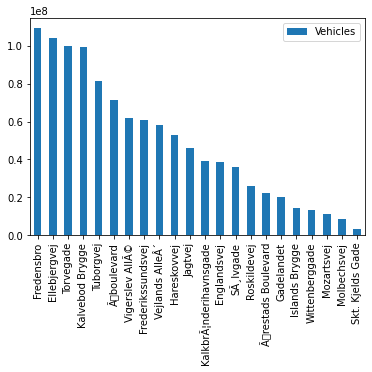

In [4]:
pd.DataFrame(totcount.values, index = list(totcount.index), columns =['Vehicles']).plot.bar()

# Let's look at how the data distribute across time


## Monthly distribution of total vehicles

The main pattern observable is the drop in traffic in July and December: Danish holiday season

<AxesSubplot:xlabel='Month'>

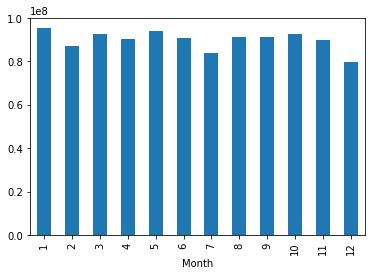

In [44]:
df.groupby('Month')['Total Vehicles'].sum().plot.bar()

## Montly distribution per Road (Total vehicles)
* The main feature that is clearly visible is the drop in taffic on nearly all roads on July, which is the month where most Copenhageners are on holidays away from the city
* a few roads that except these rule show unclear patterns that could be due to data quality issues (check if this is true after wi enclose other years

In [42]:
m = df.groupby(["Month", "Vejnavn"]).sum()["Total Vehicles"].unstack()
#m

array([[<AxesSubplot:title={'center':'Ellebjergvej'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Englandsvej'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Fredensbro'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Frederikssundsvej'}, xlabel='Month'>],
       [<AxesSubplot:title={'center':'Gadelandet'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Hareskovvej'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Islands Brygge'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Jagtvej'}, xlabel='Month'>],
       [<AxesSubplot:title={'center':'KalkbrÃ¦nderihavnsgade'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Kalvebod Brygge'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Molbechsvej'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Mozartsvej'}, xlabel='Month'>],
       [<AxesSubplot:title={'center':'Roskildevej'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Skt. Kjelds Gade'}, xlabel='Mon

C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0, flags=flags)


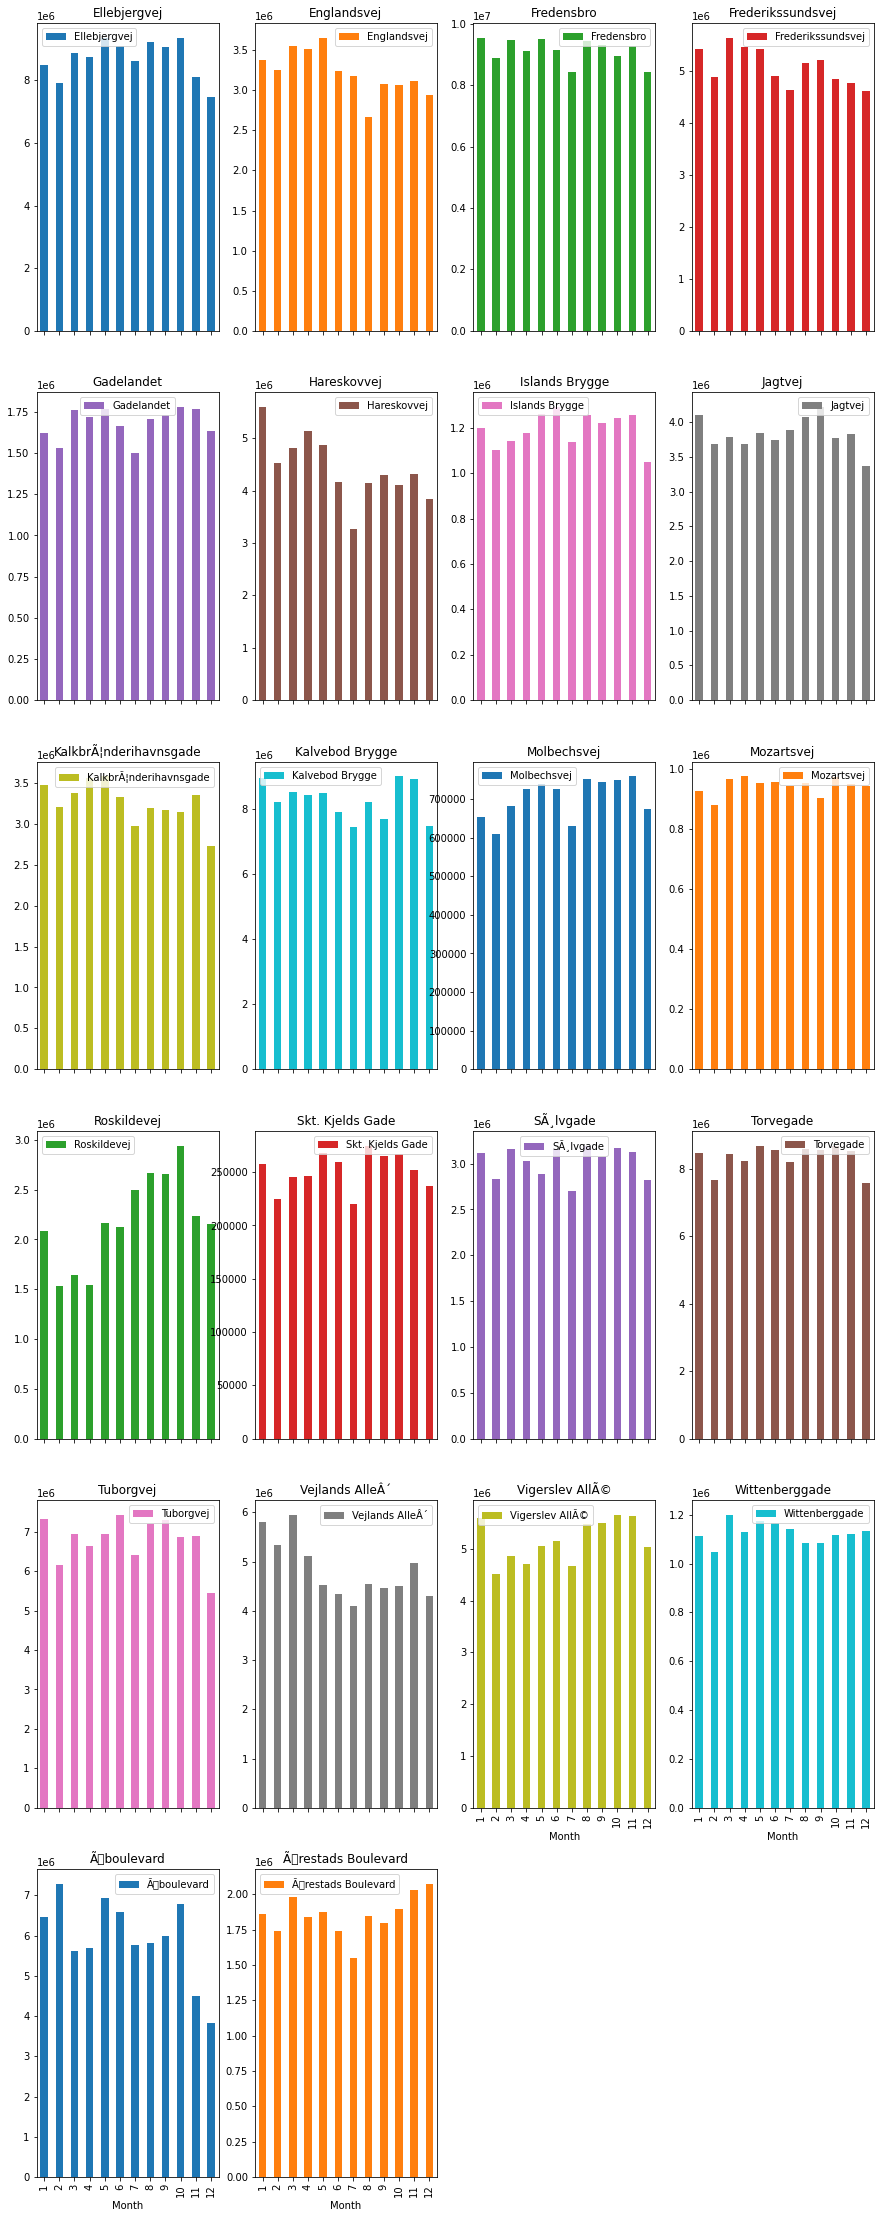

In [11]:
m.plot(kind='bar', subplots=True, figsize=(15,60), layout=(9,4))


## Weekly distribution of total vehicles

The main pattern observable is the w-e drop in traffic

<AxesSubplot:xlabel='WeekDay'>

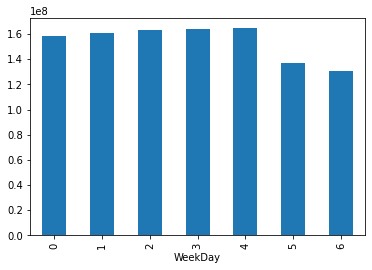

In [5]:
df.groupby('WeekDay')['Total Vehicles'].sum().plot.bar()

## Weekly distribution per Road (Total vehicles)
From the plots below a clear drop of traffic on all roads is clearly visible.
2 main exceptions to this pattern are:
* **Kalvebod Brygge** where the drop happens on Mondays and tuesdays. Althought this could be due to some quality issue about the data (we need to check if this is still the case when we include all years (now we are only working with 2008 data)
* **Jagtvej** shows a much lower drop in the w-e compared to other roads


In [43]:
w = df.groupby(["WeekDay", "Vejnavn"]).sum()["Total Vehicles"].unstack()
#w

array([[<AxesSubplot:title={'center':'Ellebjergvej'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Englandsvej'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Fredensbro'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Frederikssundsvej'}, xlabel='WeekDay'>],
       [<AxesSubplot:title={'center':'Gadelandet'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Hareskovvej'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Islands Brygge'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Jagtvej'}, xlabel='WeekDay'>],
       [<AxesSubplot:title={'center':'KalkbrÃ¦nderihavnsgade'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Kalvebod Brygge'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Molbechsvej'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Mozartsvej'}, xlabel='WeekDay'>],
       [<AxesSubplot:title={'center':'Roskildevej'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Skt. 

C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0, flags=flags)


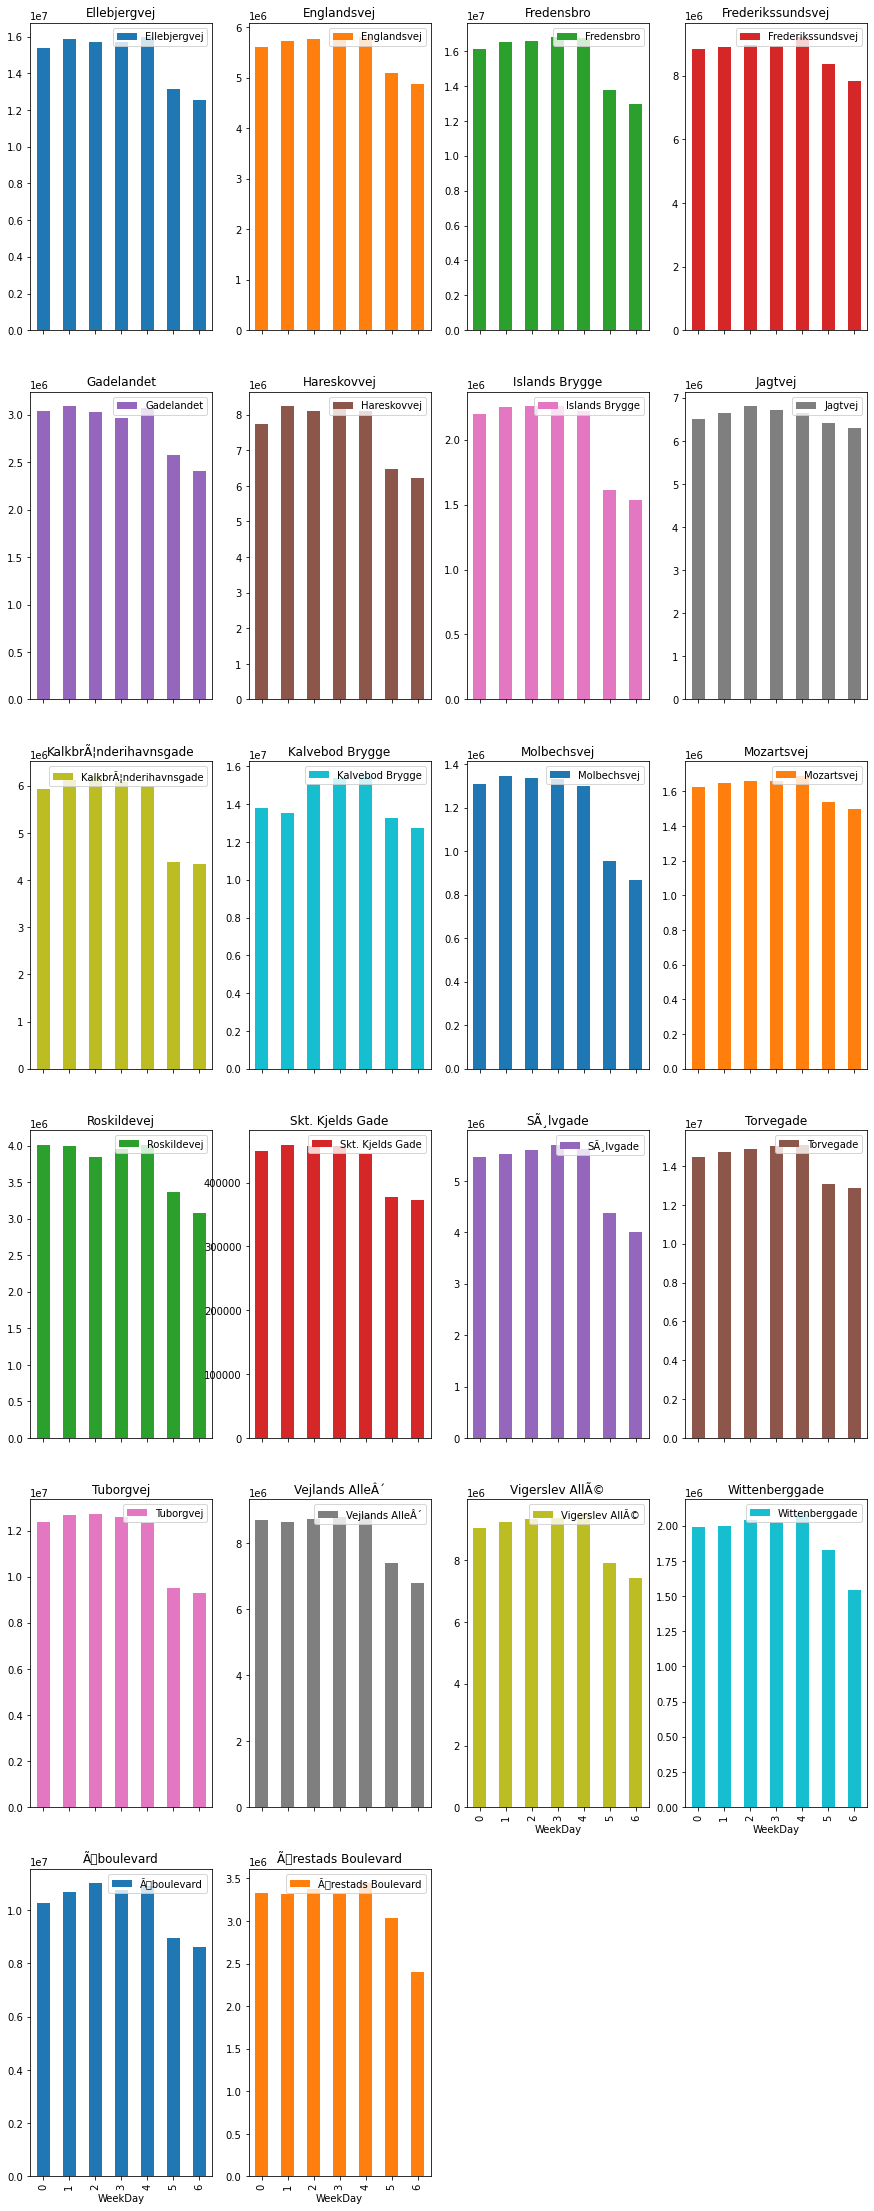

In [7]:
w.plot(kind='bar', subplots=True, figsize=(15,60), layout=(9,4))

## Day of the month distribution per Road (Total vehicles)
one pattern that can be observed is that the 31st day of the month shows a little more than half the volumes of the average of the other days. This is probably due to the fact that there are ony 7 months that contain 31 days

In [39]:
d = df.groupby(["DayOfMonth", "Vejnavn"]).sum()["Total Vehicles"].unstack()
#d

array([[<AxesSubplot:title={'center':'Ellebjergvej'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Englandsvej'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Fredensbro'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Frederikssundsvej'}, xlabel='DayOfMonth'>],
       [<AxesSubplot:title={'center':'Gadelandet'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Hareskovvej'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Islands Brygge'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Jagtvej'}, xlabel='DayOfMonth'>],
       [<AxesSubplot:title={'center':'KalkbrÃ¦nderihavnsgade'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Kalvebod Brygge'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Molbechsvej'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Mozartsvej'}, xlabel='DayOfMonth'>],
       [<AxesSubplot:title={'center':'Roskildevej'}, xlabel='DayOfMonth'>,
    

C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0, flags=flags)


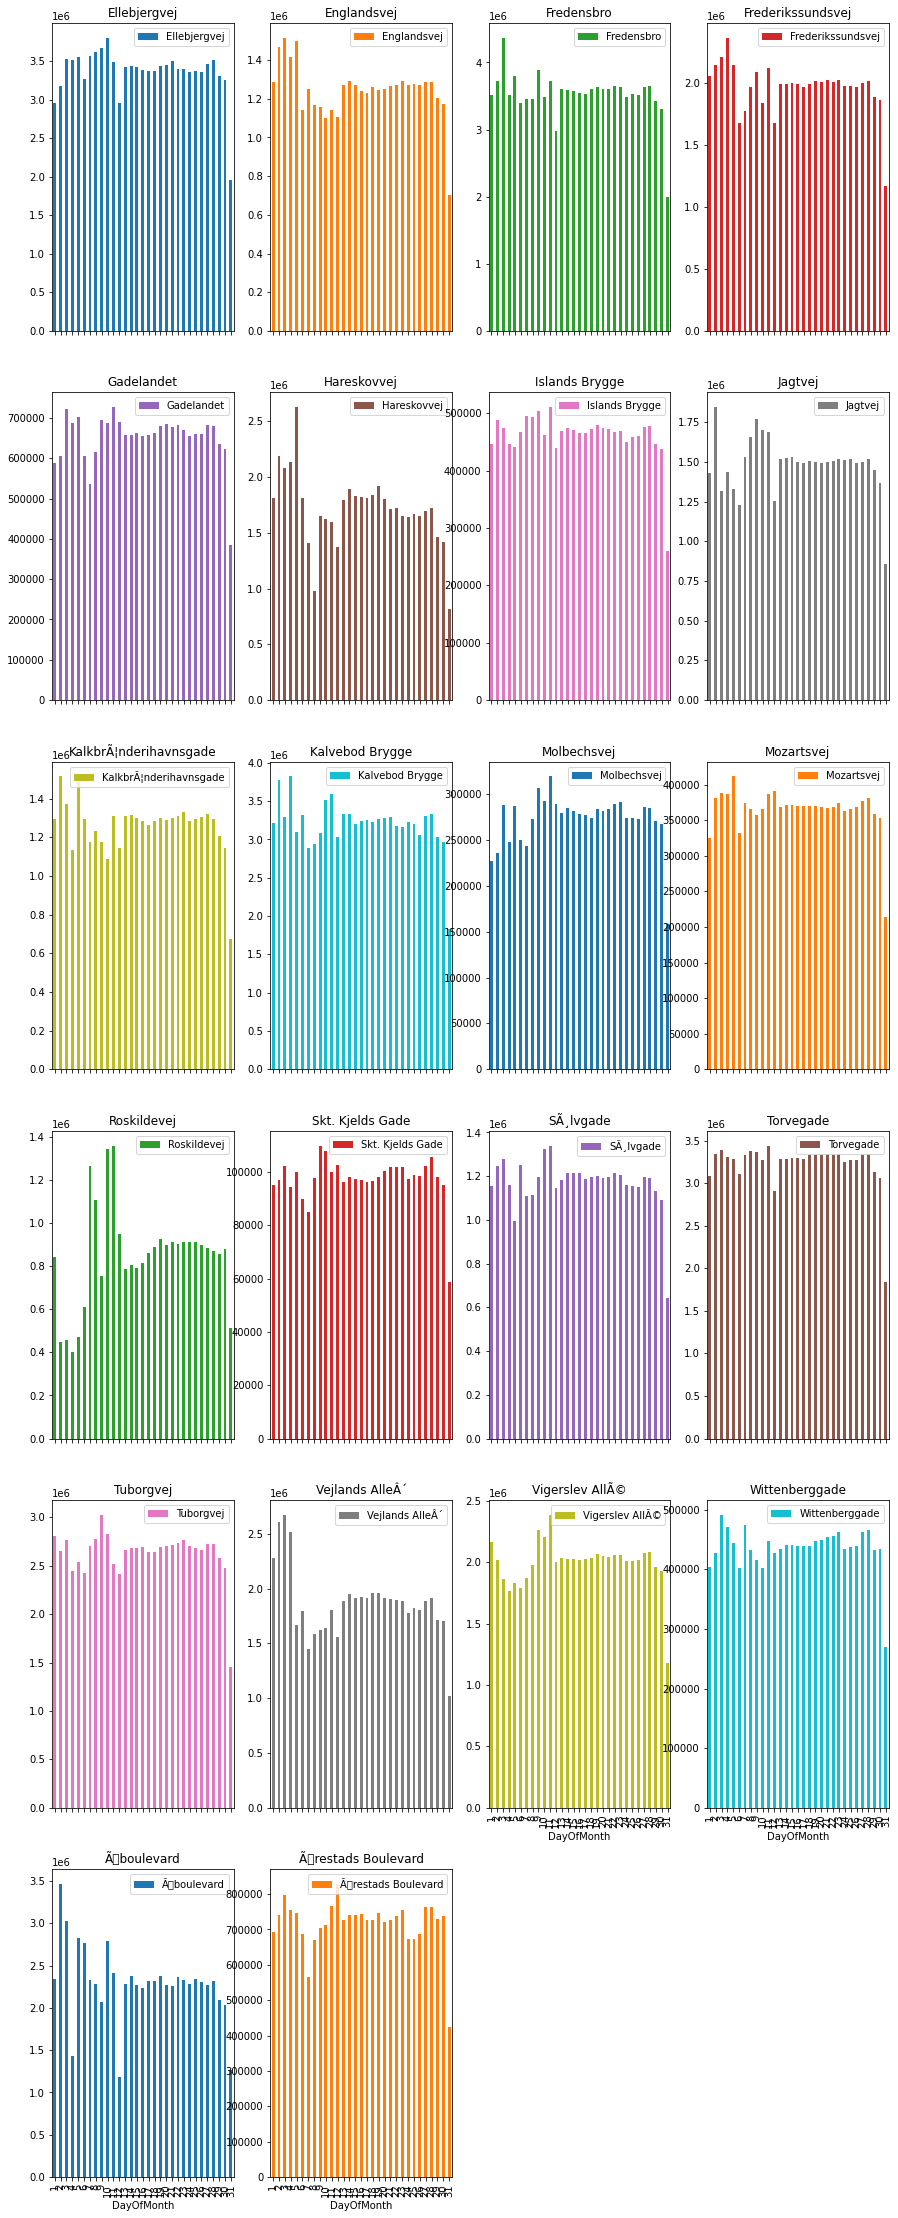

In [15]:
d.plot(kind='bar', subplots=True, figsize=(15,60), layout=(9,4))

## Hour distribution per Road (Total vehicles)
**Nearly all roads share the same pattern in hourly traffic flows:**
- Midnight to 5am: very low traffic 
- 6-8am: vehicles volumes become consistent for 3 hours and then slow down for a couple of hours
- 11 to 15-16: traffic volumes start growing again until they peack
- 17-18: vehicles numbers drop consistently. Dinner time in Denmark
- 19-23: the traffic flows slowly reduce

In [40]:
h = df.groupby(["Hour", "Vejnavn"]).sum()["Total Vehicles"].unstack()
#h

array([[<AxesSubplot:title={'center':'Ellebjergvej'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Englandsvej'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Fredensbro'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Frederikssundsvej'}, xlabel='Hour'>],
       [<AxesSubplot:title={'center':'Gadelandet'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Hareskovvej'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Islands Brygge'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Jagtvej'}, xlabel='Hour'>],
       [<AxesSubplot:title={'center':'KalkbrÃ¦nderihavnsgade'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Kalvebod Brygge'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Molbechsvej'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Mozartsvej'}, xlabel='Hour'>],
       [<AxesSubplot:title={'center':'Roskildevej'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Skt. Kjelds Gade'}, xlabel='Hour'>,
        

C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0, flags=flags)


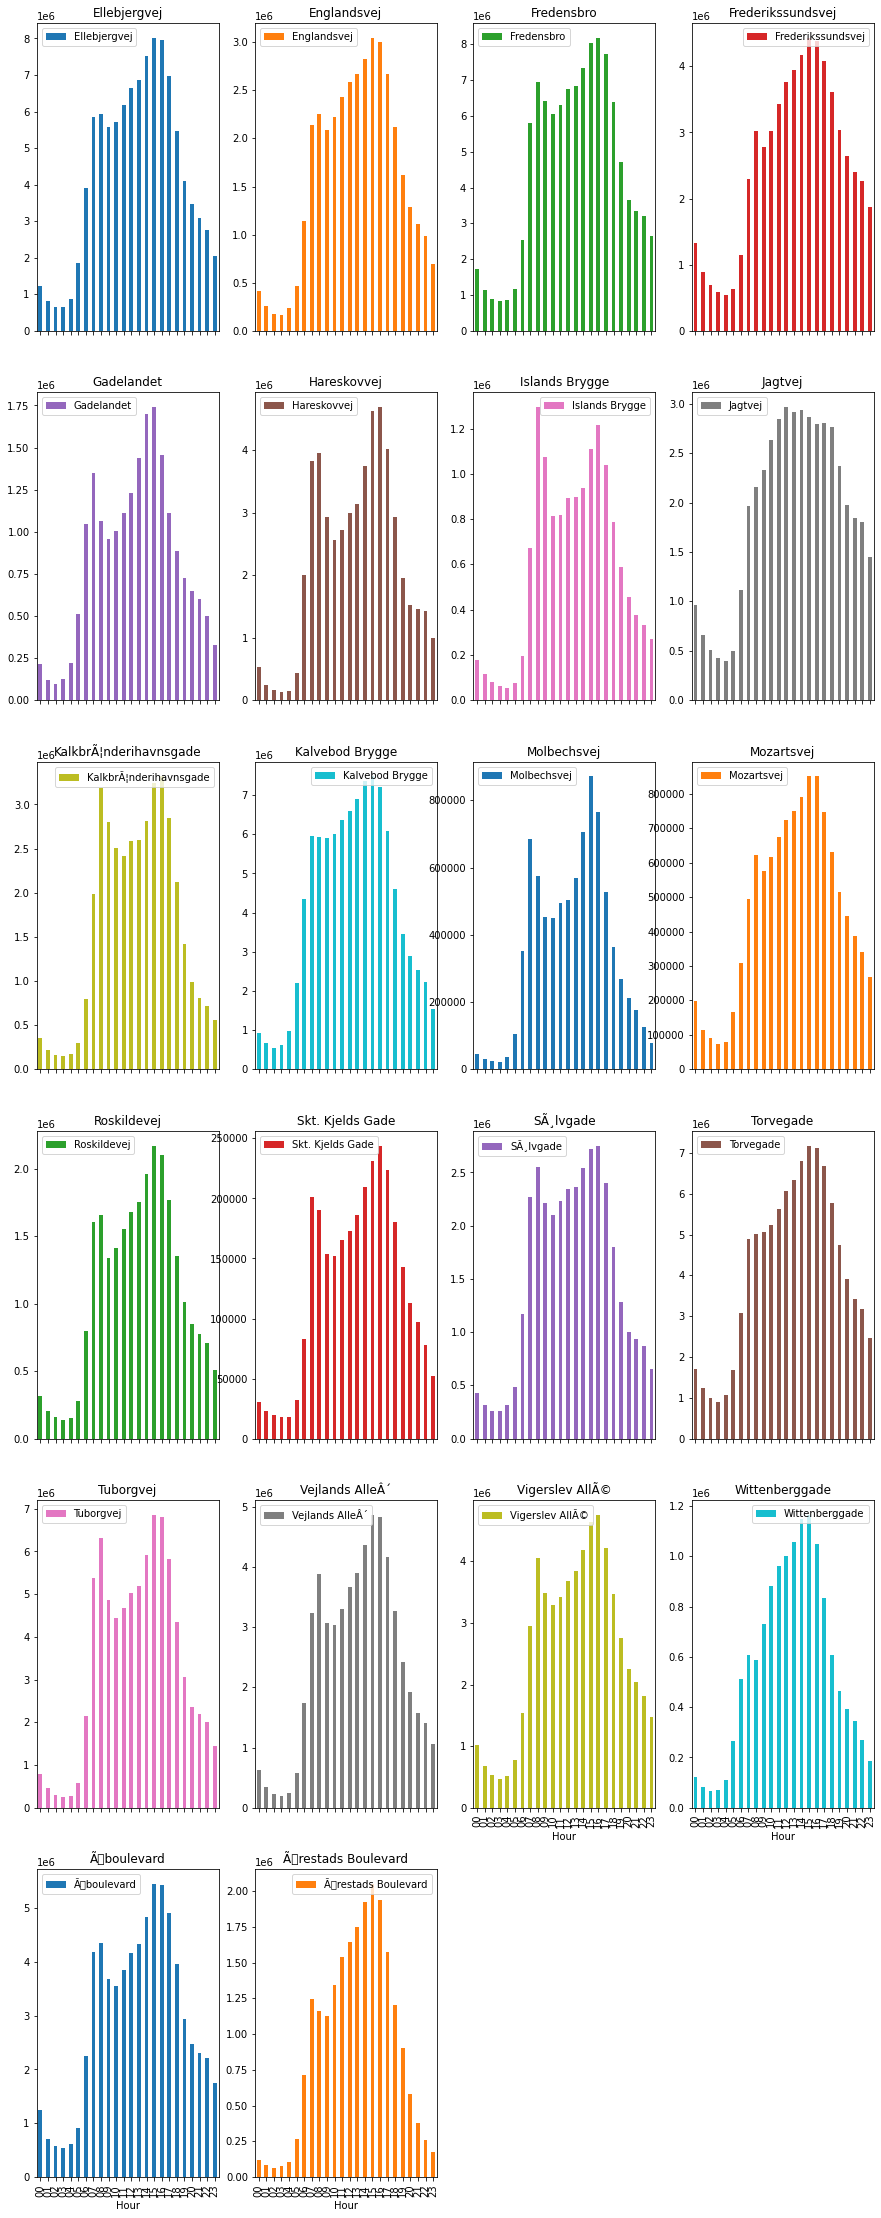

In [19]:
h.plot(kind='bar', subplots=True, figsize=(15,60), layout=(9,4))

## Hour distribution per Road (Net Entry-Exit flows)
**NOTE: the Exit-Entry analysis is based on one big assumptions: roads numbering follows an ascending order that starts at zero from the City center and then increases with the distance from the City center

**Most roads share the same pattern shapes, but not all:**
- Midnight to 4am: most roads show cars exiting the city
- 5-9am: vehicles entering the city are the majority and inward volumes constantly increase until they peak around 9-10
- 11 to 15-16: inward traffic volumes start dwindling until the outwarding vehicles start taking over from 15
- 15-18: majority of vehicles are the one exiting the city
- 19-23: no clear pattern: some roads show the majority of vehicles enterring the city again, while others show the majority of cars exiting the city, depending on the timeframe
- some roads, like Roskildevej and Torvegade show opposite patterns than the one described above. The reason is probably because these roads lead to specific locations that attract a high number of workers, respectively **Roskilde and Amager**
- some other roads instead show systematically net inward or systematic net outward flow of vehicles during the whole day. These are, respectively:
  - .... (inward flow)
  - .... (ouward flow)

In [41]:
hd = df.groupby(["Hour", "Vejnavn"]).sum()["Net Traffic Flow"].unstack()
#hd

array([[<AxesSubplot:title={'center':'Ellebjergvej'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Englandsvej'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Fredensbro'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Frederikssundsvej'}, xlabel='Hour'>],
       [<AxesSubplot:title={'center':'Gadelandet'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Hareskovvej'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Islands Brygge'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Jagtvej'}, xlabel='Hour'>],
       [<AxesSubplot:title={'center':'KalkbrÃ¦nderihavnsgade'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Kalvebod Brygge'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Molbechsvej'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Mozartsvej'}, xlabel='Hour'>],
       [<AxesSubplot:title={'center':'Roskildevej'}, xlabel='Hour'>,
        <AxesSubplot:title={'center':'Skt. Kjelds Gade'}, xlabel='Hour'>,
        

C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0, flags=flags)


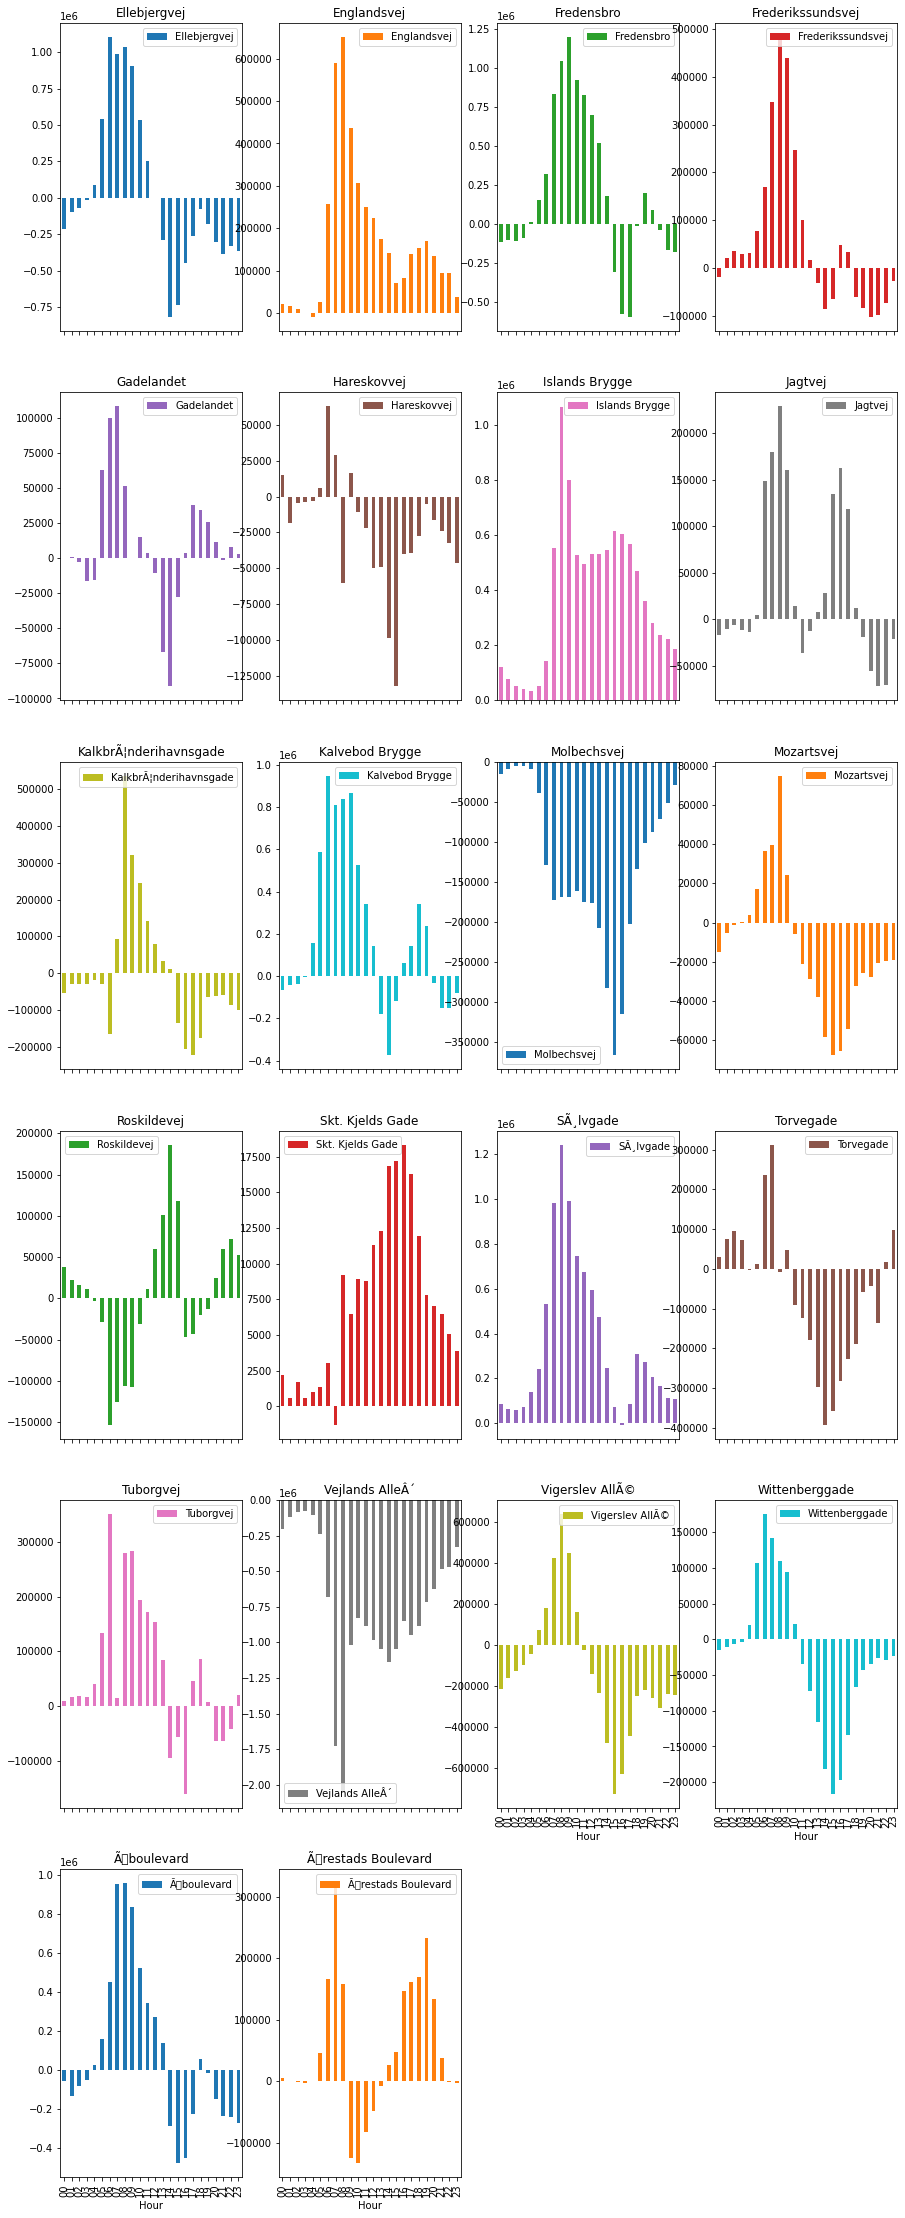

In [21]:
hd.plot(kind='bar', subplots=True, figsize=(15,60), layout=(9,4))

# Classifying traffic data by Roads

The visualization of Hourly Net Flows (vehicles leaving - vehicles entering the city) above shows that, for example, Roskildevej has a very different pattern from other roads: cars on Roskildevej are leaving the city in the morning and are coming back at night. This is probably due to the fact that the number of Copenhageners working in Roskilde is higher than the number of Roskilde residents working in Copenhagen.

Based on this visual information we have build a classifier that can identify traffic flows on Roskildevej from roads that have a completely different hourly traffic flow (we have chosen Ellebjergvej for our example).

Our classifier uses Random Forests and yields around 80% accurate predictions for both the training and test data


In [35]:
# Test without Weather data

### data preprocessing

# selecting our sample: focussing on data for 2011, 2012, 2013 and 2 roads only
dfml = df[(df['Year'].isin([2011,2012,2013]))
         & (df['Vejnavn'].isin(['Ellebjergvej','Roskildevej']))]  

# keeping only: Hour-of-the-day, Day-of-the-week, Month-of-the-year, and PD-District
dfml = dfml[['Vejnavn','Net Traffic Flow', 'Hour']]
dfml
# chosing a subset of categories and other features
# df1 = df1[(df1['Category'].isin(['PROSTITUTION', 'FRAUD'])) #'VEHICLE THEFT'
#           & (data['Resolution'] == 'ARREST, BOOKED') 
#           & (data['Year'].isin([2017,2018]))
#         ]

# setting sample size equal to 10.000 for all classes
#cs = 10000

# extracting random samples of equally sized classes
#df = pd.DataFrame()
#df = df.append(df1[df1['Category'] == 'PROSTITUTION'].sample(n=cs, random_state=1, replace=True))
#df = df.append(df1[df1['Category'] == 'FRAUD'].sample(n=cs, random_state=1, replace=True)) 

Vejnavn  Net Traffic Flow Hour
index                                                        
Ellebjergvej2011-01-0100  Ellebjergvej             -24.0   00
Ellebjergvej2011-02-0100  Ellebjergvej             -28.0   00
Ellebjergvej2011-03-0100  Ellebjergvej             -28.0   00
Ellebjergvej2011-04-0100  Ellebjergvej             -30.0   00
Ellebjergvej2011-05-0100  Ellebjergvej             -43.0   00
...                                ...               ...  ...
Roskildevej2013-12-2723    Roskildevej              48.0   23
Roskildevej2013-12-2823    Roskildevej             -11.0   23
Roskildevej2013-12-2923    Roskildevej              28.0   23
Roskildevej2013-12-3023    Roskildevej             150.0   23
Roskildevej2013-12-3123    Roskildevej            -160.0   23

[42240 rows x 3 columns]

In [36]:
# encoding data with LabelEncoder
from sklearn.preprocessing import LabelEncoder

#creating labelencoder
le = LabelEncoder()
# encoding string labels (Category is the target variable)
labels = le.fit_transform(dfml['Vejnavn'])

# encoding string features (not necessary)
#NetTraffic =le.fit_transform(dfml['Hour'])

features=dfml[['Net Traffic Flow', 'Hour']]

#Split Train/test datasets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
clf = clf.fit(X_train,  y_train)

# measuring the classification performance of the RF classifier through cross_val_score
from sklearn.model_selection import cross_val_score
np.mean(cross_val_score(clf, X_train,  y_train, cv=10))

0.7954770318021203

In [37]:
# Measuring RF prediction performance (in the Test sample)
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test) # 0:Overcast, 2:Mild
print(classification_report(y_test, y_pred))#, target_names=target_names))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      8409
           1       0.75      0.73      0.74      5531

    accuracy                           0.79     13940
   macro avg       0.78      0.78      0.78     13940
weighted avg       0.79      0.79      0.79     13940



# Visualize data in space/time to identify some patterns

# Radhusplads

In [26]:
import folium

map_hooray = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12.5)

folium.Marker([55.6761, 12.5683], 
              popup='RadHus Plads', 
              icon=folium.Icon(color='blue')
             ).add_to(map_hooray)

map_hooray

# Visualizing some traffic data (randomized space data)

In [27]:
df1 = df[(df['DayOfMonth'].isin([1,2,3,4,5,2,3,4,5,6,7,8,9,10,
                                11,12,13,14,15,16,17,18,19,20,
                                21,22,23,24,25,26,27,28,29,30,31]))
         & (df['Hour'].isin(['07','08']))
         & (df['Month'].isin([6, 7]))
         & (df['Year'] == 2012)]

df1

Vejnavn       Dato        Lat  \
index                                                                        
Ellebjergvej2012-06-0107                Ellebjergvej 2012-06-01  55.650543   
Ellebjergvej2012-07-0107                Ellebjergvej 2012-07-01  55.650543   
Ellebjergvej2012-06-0207                Ellebjergvej 2012-06-02  55.650543   
Ellebjergvej2012-07-0207                Ellebjergvej 2012-07-02  55.650543   
Ellebjergvej2012-06-0307                Ellebjergvej 2012-06-03  55.650543   
...                                              ...        ...        ...   
Ãrestads Boulevard2012-07-1008  Ãrestads Boulevard 2012-07-10  55.637367   
Ãrestads Boulevard2012-06-1108  Ãrestads Boulevard 2012-06-11  55.637367   
Ãrestads Boulevard2012-07-1108  Ãrestads Boulevard 2012-07-11  55.637367   
Ãrestads Boulevard2012-06-1208  Ãrestads Boulevard 2012-06-12  55.637367   
Ãrestads Boulevard2012-07-1208  Ãrestads Boulevard 2012-07-12  55.637367   

                                       Lon Hour  Total Vehicles  \
index                                                             
Ellebjergvej2012-06-0107         12.510778   07          2708.0   
Ellebjergvej2012-07-0107         12.510778   07           458.0   
Ellebjergvej2012-06-0207         12.510778   07          2572.0   
Ellebjergvej2012-07-0207         12.510778   07          2660.0   
Ellebjergvej2012-06-0307         12.510778   07          2794.0   
...                                    ...  ...             ...   
Ãrestads Boulevard2012-07-1008  12.582357   08           127.0   
Ãrestads Boulevard2012-06-1108  12.582357   08           551.0   
Ãrestads Boulevard2012-07-1108  12.582357   08           575.0   
Ãrestads Boulevard2012-06-1208  12.582357   08           588.0   
Ãrestads Boulevard2012-07-1208  12.582357   08           586.0   

                                 Entering Vehicles  Leaving Vehicles  \
index                                                                  
Ellebjergvej2012-06-0107                    1644.0            1064.0   
Ellebjergvej2012-07-0107                     217.0             241.0   
Ellebjergvej2012-06-0207                    1506.0            1066.0   
Ellebjergvej2012-07-0207                    1502.0            1158.0   
Ellebjergvej2012-06-0307                    1616.0            1178.0   
...                                            ...               ...   
Ãrestads Boulevard2012-07-1008               53.0              74.0   
Ãrestads Boulevard2012-06-1108              311.0             240.0   
Ãrestads Boulevard2012-07-1108              298.0             277.0   
Ãrestads Boulevard2012-06-1208              350.0             238.0   
Ãrestads Boulevard2012-07-1208              319.0             267.0   

                                 Net Traffic Flow   Lat_rand   Lon_rand  \
index                                                                     
Ellebjergvej2012-06-0107                    580.0  55.649925  12.509153   
Ellebjergvej2012-07-0107                    -24.0  55.650160  12.511771   
Ellebjergvej2012-06-0207                    440.0  55.649929  12.510840   
Ellebjergvej2012-07-0207                    344.0  55.649506  12.514581   
Ellebjergvej2012-06-0307                    438.0  55.650847  12.513631   
...                                           ...        ...        ...   
Ãrestads Boulevard2012-07-1008             -21.0  55.636316  12.580715   
Ãrestads Boulevard2012-06-1108              71.0  55.636649  12.576869   
Ãrestads Boulevard2012-07-1108              21.0  55.638765  12.585044   
Ãrestads Boulevard2012-06-1208             112.0  55.636945  12.580807   
Ãrestads Boulevard2012-07-1208              52.0  55.635668  12.579034   

                                   DayName  WeekDay  DayOfMonth  Week  Month  \
index                                                                          
Ellebjergvej2012-06-0107            Friday        4           1    22      6   
Elleb

In [28]:
map2 = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12)

folium.Marker([55.6761, 12.5683], 
              popup='City Hall', 
              icon=folium.Icon(color='blue')
             ).add_to(map2)

for i in range(len(df1)):
    folium.Circle(location=[df1.iloc[i]['Lat_rand'], df1.iloc[i]['Lon_rand']],
                  popup=df1.iloc[i]['Month'],
                  radius=4, #data.iloc[i]['value']*10000,
                  color='crimson',
                  fill=True,
                  fill_color='crimson'
                 ).add_to(map2)

map2

# Heatmap

In [29]:
from folium.plugins import HeatMap

map_hooray = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = df1[['Lat', 'Lon']]
#heat_df = heat_df.dropna(axis=0, subset=['Y','X'])



# List comprehension to make out list of lists
heat_data = [[row['Lat'],row['Lon']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(map_hooray)

# Display the map
map_hooray

# HeatMapWithTime  (Weekdays - NON random locations) 

In [30]:
from folium import plugins

map_hooray = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = df1[['Lat', 'Lon','Lat_rand', 'Lon_rand']]
#heat_df = heat_df.dropna(axis=0, subset=['Y','X'])

# List comprehension to make out list of lists
heat_data = [[row['Lat'],row['Lon']] for index, row in heat_df.iterrows()]

# Create weight column, using date
heat_df['Weight'] = df1['WeekDay']
heat_df['Weight'] = heat_df['Weight'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['Lat','Lon', 'Weight'])

# List comprehension to make out list of lists
heat_data = [[[row['Lat'],row['Lon']] for index, row in heat_df[heat_df['Weight'] == i].iterrows()] for i in range(0,7)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(map_hooray)
# Display the map
map_hooray

<ipython-input-30-8178631b64e2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_df['Weight'] = df1['WeekDay']
<ipython-input-30-8178631b64e2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_df['Weight'] = heat_df['Weight'].astype(float)


# HeatMapWithTime  (Weekdays - randomized locations)

In [31]:
from folium import plugins

map_hooray = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12)

heat_rn = pd.concat([heat_df['Lat_rand'], heat_df['Lon_rand'], heat_df['Weight']], axis=1)

# List comprehension to make out list of lists
heat_data_rn = [[[row['Lat_rand'],row['Lon_rand']] for index, row in heat_rn[heat_rn['Weight'] == i].iterrows()] for i in range(0,7)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data_rn,auto_play=True,max_opacity=0.8)
hm.add_to(map_hooray)
# Display the map
map_hooray

# HeatMapWithTime  (Hours - only 2 roads) - we could skip this one

In [32]:
df3 = df[(df['DayOfMonth'].isin([1,2,3,4,5,2,3,4,5,6,7,8,9,10,
                                11,12,13,14,15,16,17,18,19,20,
                                21,22,23,24,25,26,27,28,29,30,31]))
         & (df['Vejnavn'].isin(['Roskildevej','Ellebjergvej']))
#         & (df['Hour'].isin(['07','08']))
         & (df['Month'].isin([6, 7]))
         & (df['Year'] == 2012)]
#        & (df['Vej-Id'] == 'T')]

#df3

In [33]:
map3 = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12)

folium.Marker([55.6761, 12.5683], 
              popup='City Hall', 
              icon=folium.Icon(color='blue')
             ).add_to(map3)

for i in range(len(df3)):
    folium.Circle(location=[df3.iloc[i]['Lat_rand'], df3.iloc[i]['Lon_rand']],
                  popup=df3.iloc[i]['Month'],
                  radius=4, #data.iloc[i]['value']*10000,
                  color='crimson',
                  fill=True,
                  fill_color='crimson'
                 ).add_to(map3)

map3

In [34]:
from folium import plugins

map_hooray = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = df3[['Lat_rand', 'Lon_rand']]
#heat_df = heat_df.dropna(axis=0, subset=['Y','X'])

# List comprehension to make out list of lists
heat_data = [[row['Lat_rand'],row['Lon_rand']] for index, row in heat_df.iterrows()]

# Create weight column, using date
heat_df['Weight'] = df3['Hour']
heat_df['Weight'] = heat_df['Weight'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['Lat_rand','Lon_rand', 'Weight'])

# List comprehension to make out list of lists
heat_data = [[[row['Lat_rand'],row['Lon_rand']] for index, row in heat_df[heat_df['Weight'] == i].iterrows()] for i in range(0,24)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(map_hooray)
# Display the map
map_hooray

<ipython-input-34-7ff84378e29a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_df['Weight'] = df3['Hour']
<ipython-input-34-7ff84378e29a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_df['Weight'] = heat_df['Weight'].astype(float)


# Using data visualizations to check for data quality issues 

# (spotting bad data)

## Yearly distribution per Road
* The main feature that is clearly visible is the drop in taffic on nearly all roads on July, which is the month where most Copenhageners are on holidays away from the city
* a few roads that except these rule show unclear patterns that could be due to data quality issues (check if this is true after wi enclose other years

In [38]:
y = df.groupby(["Year", "Vejnavn"]).sum()["Total Vehicles"].unstack()
#y

array([[<AxesSubplot:title={'center':'Ellebjergvej'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Englandsvej'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Fredensbro'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Frederikssundsvej'}, xlabel='Year'>],
       [<AxesSubplot:title={'center':'Gadelandet'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Hareskovvej'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Islands Brygge'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Jagtvej'}, xlabel='Year'>],
       [<AxesSubplot:title={'center':'KalkbrÃ¦nderihavnsgade'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Kalvebod Brygge'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Molbechsvej'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Mozartsvej'}, xlabel='Year'>],
       [<AxesSubplot:title={'center':'Roskildevej'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Skt. Kjelds Gade'}, xlabel='Year'>,
        

C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0, flags=flags)


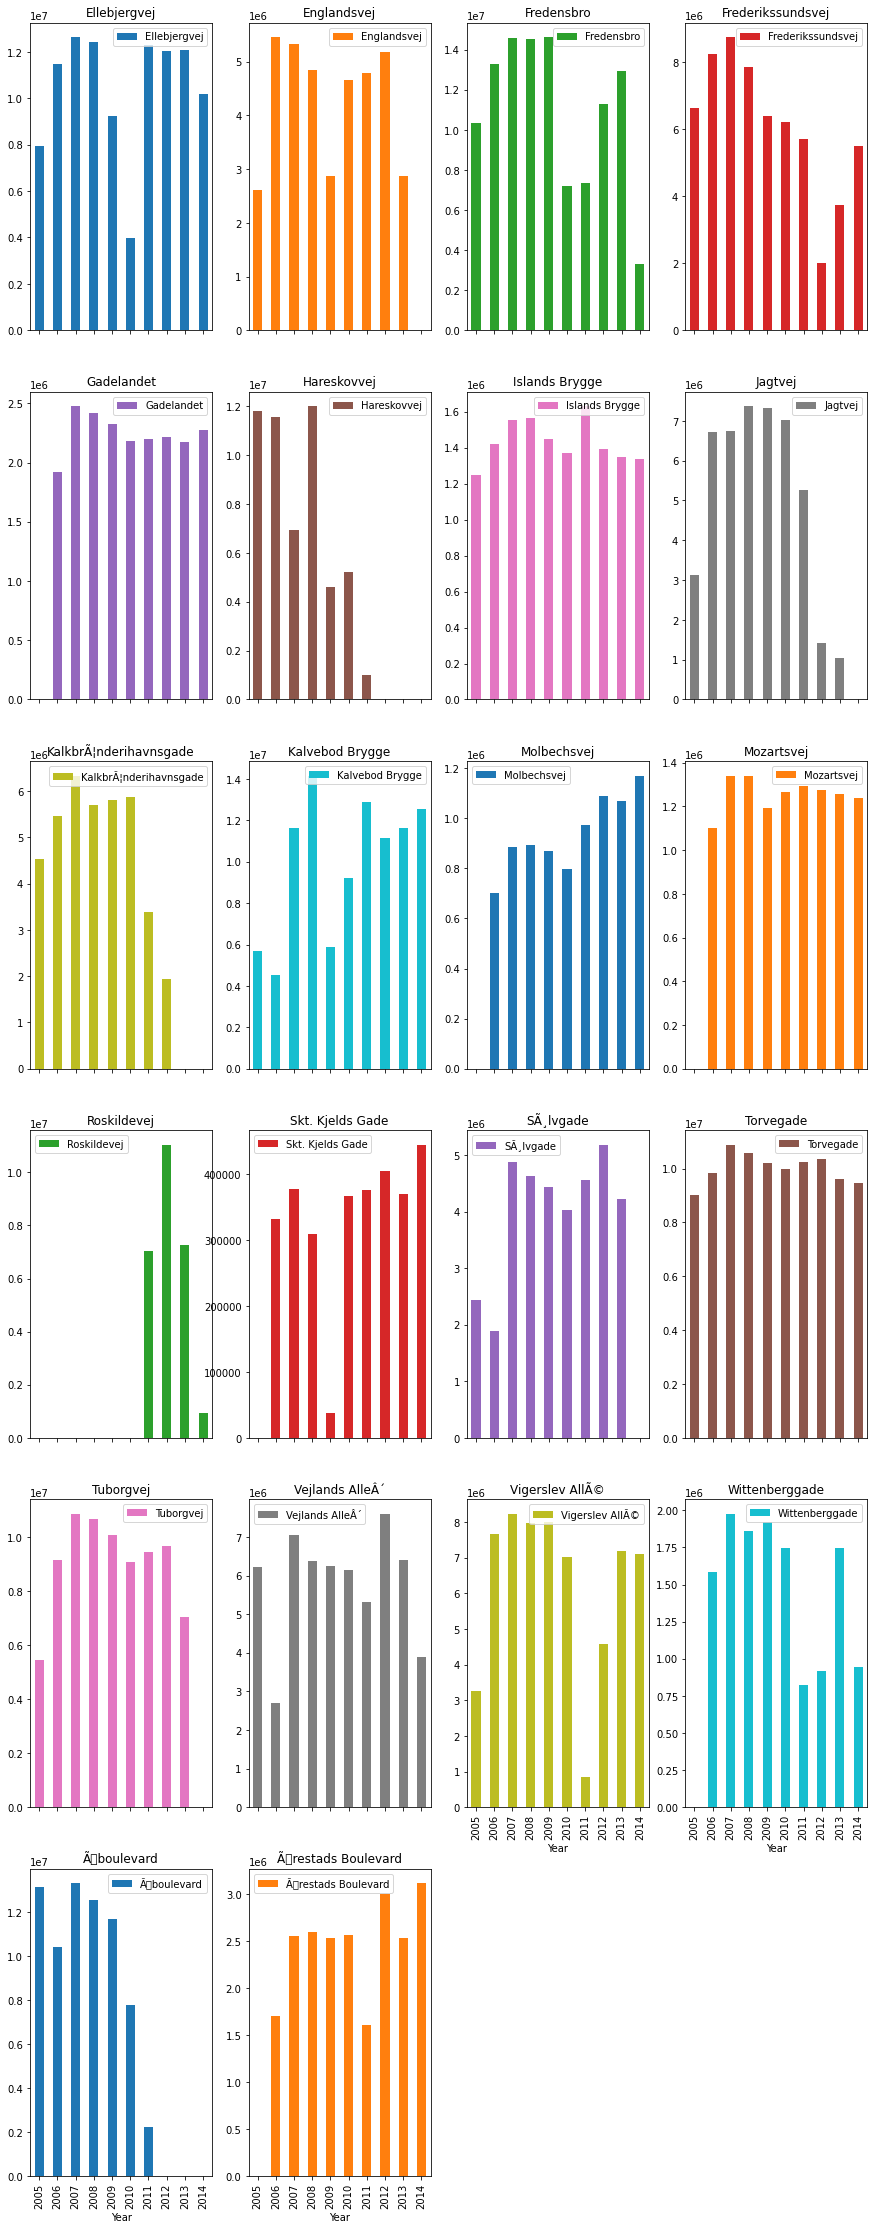

In [23]:
y.plot(kind='bar', subplots=True, figsize=(15,60), layout=(9,4))

## Montly distribution per Road (Net Entry-Exit Flows)

In [45]:
md = df.groupby(["Month", "Vejnavn"]).sum()["Net Traffic Flow"].unstack()
md

Vejnavn  Ellebjergvej  Englandsvej  Fredensbro  Frederikssundsvej  Gadelandet  \
Month                                                                           
1             40409.0     355094.0    338904.0           132834.0     11893.0   
2             45831.0     349762.0    332529.0           105058.0     16224.0   
3             49684.0     412123.0    394421.0           167926.0     14301.0   
4            221088.0     418662.0    370266.0           151695.0     20001.0   
5             79891.0     426645.0    386239.0           150208.0     16399.0   
6             59845.0     291121.0    379219.0           121757.0     18677.0   
7             78473.0     285898.0    448682.0            52003.0     22523.0   
8             61251.0     255861.0    382194.0           119363.0     28917.0   
9             57310.0     319897.0    373066.0           103810.0     20981.0   
10            60235.0     343487.0    369260.0           108247.0     30917.0   
11            53178.0     346791.0    552340.0           111253.0     22529.0   
12            50665.0     278254.0    347704.0           118440.0      9393.0   

Vejnavn  Hareskovvej  Islands Brygge   Jagtvej  KalkbrÃ¦nderihavnsgade  \
Month                                                                    
1          -153570.0        780491.0   55308.0                 63105.0   
2           -25397.0        724137.0   37997.0                -24390.0   
3           -42429.0        738088.0   59344.0                -25243.0   
4           -53062.0        763645.0   56147.0                -43004.0   
5           -66445.0        773418.0   42505.0                -20220.0   
6           -43261.0        776375.0   41547.0                -39480.0   
7           -24700.0        704011.0   67021.0                -22770.0   
8           -30865.0        784844.0   64047.0                -18179.0   
9           -24044.0        770430.0  106468.0                -14781.0   
10          -27647.0        795856.0  116201.0                -23519.0   
11          -41102.0        811010.0  113578.0                 82793.0   
12          -20279.0        667534.0   93333.0                 84025.0   

Vejnavn  Kalvebod Brygge  ...  Roskildevej  Skt. Kjelds Gade  SÃ¸lvgade  \
Month                     ...                                             
1               503354.0  ...       9512.0           11706.0   715531.0   
2               425131.0  ...       6553.0           10857.0   642786.0   
3               395741.0  ...       3626.0           15406.0   727104.0   
4               563993.0  ...       6047.0           15277.0   701942.0   
5               461875.0  ...      10156.0           17962.0   653949.0   
6               418043.0  ...       6425.0           16475.0   747985.0   
7               431347.0  ...      11882.0           13117.0   687983.0   
8               459716.0  ...       3237.0           16839.0   736554.0   
9               394902.0  ...      10642.0           16525.0   726850.0   
10              264042.0  ...       4198.0           16213.0   765666.0   
11              196388.0  ...       7255.0           12236.0   717943.0   
12              248543.0  ...      15589.0           14398.0   656068.0   

Vejnavn  Torvegade  Tuborgvej  Vejlands AlleÂ´  Vigerslev AllÃ©  \
Month                                                             
1        -151844.0   139445.0       -1451295.0        -315086.0   
2        -126750.0   118701.0       -1268657.0        -205077.0   
3        -140217.0   126312.0       -1322738.0        -167827.0   
4        -107418.0   112535.0       -1608748.0        -158449.0   
5        -125353.0   135054.0       -1679618.0        -159928.0   
6        -119578.0   140250.0       -1702545.0        -180408.0   
7         -73172.0   118042.0       -1385765.0        -283265.0   
8        -136515.0   117603.0       -1353994.0        -267313.0   
9        -123242.0   107663.0       -1451163.0        -274055.0   
10       -103799.0   107166.0       -154

array([[<AxesSubplot:title={'center':'Ellebjergvej'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Englandsvej'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Fredensbro'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Frederikssundsvej'}, xlabel='Month'>],
       [<AxesSubplot:title={'center':'Gadelandet'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Hareskovvej'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Islands Brygge'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Jagtvej'}, xlabel='Month'>],
       [<AxesSubplot:title={'center':'KalkbrÃ¦nderihavnsgade'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Kalvebod Brygge'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Molbechsvej'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Mozartsvej'}, xlabel='Month'>],
       [<AxesSubplot:title={'center':'Roskildevej'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Skt. Kjelds Gade'}, xlabel='Mon

C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0, flags=flags)


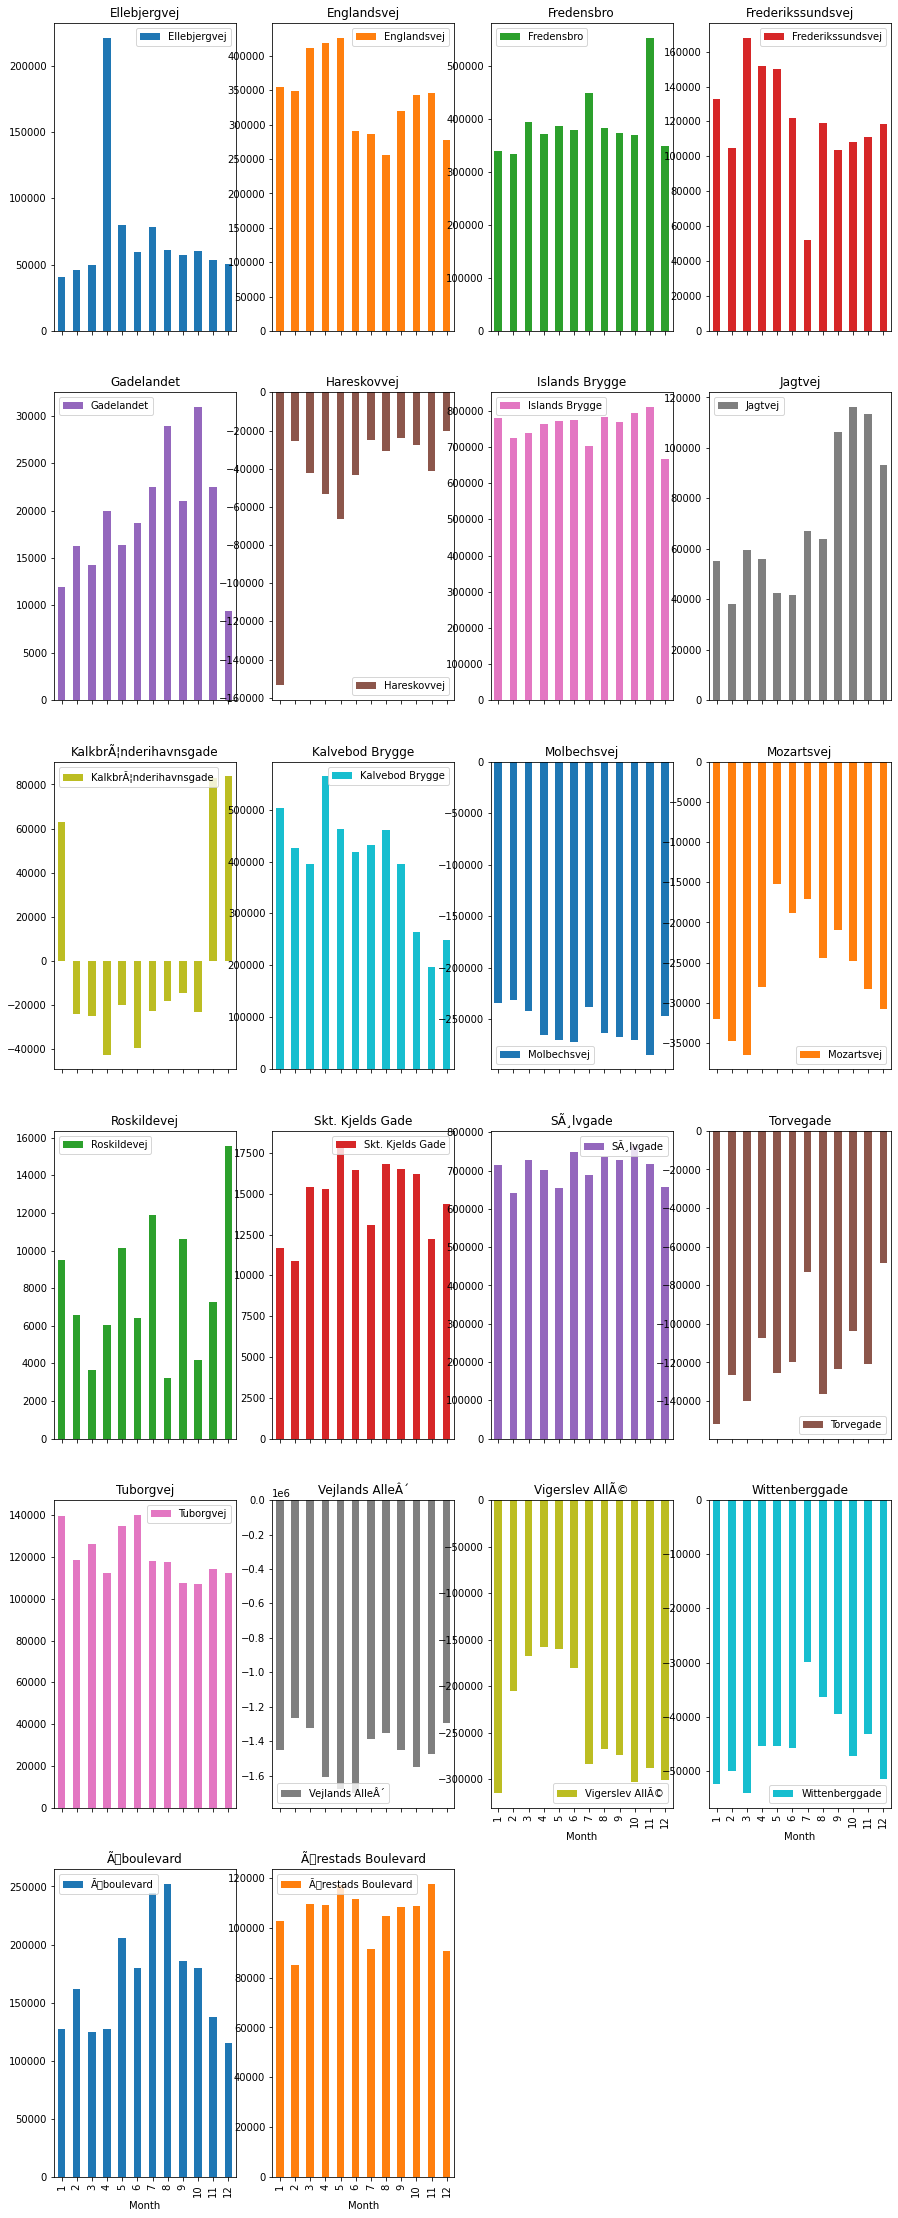

In [13]:
md.plot(kind='bar', subplots=True, figsize=(15,60), layout=(9,4))

## Weekly distribution per Road (Entry-Exit flows)

In [8]:
wd = df.groupby(["WeekDay", "Vejnavn"]).sum()["Net Traffic Flow"].unstack()
wd

Vejnavn  Ellebjergvej  Englandsvej  Fredensbro  Frederikssundsvej  Gadelandet  \
WeekDay                                                                         
0            150161.0     593896.0    624255.0           183026.0     37456.0   
1            127537.0     608030.0    649349.0           220955.0     34957.0   
2             98770.0     601362.0    638069.0           213272.0     29586.0   
3             88346.0     606177.0    695211.0           232528.0     31022.0   
4            117895.0     609205.0    741935.0           239527.0     38326.0   
5             82599.0     530156.0    713879.0           175690.0     26291.0   
6            192552.0     534769.0    612126.0           177596.0     35117.0   

Vejnavn  Hareskovvej  Islands Brygge   Jagtvej  KalkbrÃ¦nderihavnsgade  \
WeekDay                                                                  
0           -47085.0       1382558.0  128846.0                 21661.0   
1           -81675.0       1424359.0  133370.0                 36564.0   
2           -69613.0       1421942.0  158785.0                  8435.0   
3           -85613.0       1427258.0  127318.0                  6803.0   
4          -105080.0       1405195.0  153907.0                 23464.0   
5          -101931.0       1040679.0   75138.0                -39060.0   
6           -61804.0        987848.0   76132.0                -59530.0   

Vejnavn  Kalvebod Brygge  ...  Roskildevej  Skt. Kjelds Gade  SÃ¸lvgade  \
WeekDay                   ...                                             
0               793123.0  ...      -3376.0           26944.0  1220097.0   
1               708107.0  ...       7791.0           26820.0  1237980.0   
2               726297.0  ...      12519.0           28206.0  1254890.0   
3               711462.0  ...      26567.0           28302.0  1284309.0   
4               729026.0  ...      21471.0           25423.0  1309932.0   
5               599267.0  ...      22270.0           19132.0  1144081.0   
6               495793.0  ...       7880.0           22184.0  1029072.0   

Vejnavn  Torvegade  Tuborgvej  Vejlands AlleÂ´  Vigerslev AllÃ©  \
WeekDay                                                           
0        -334478.0   173752.0       -2607253.0        -360005.0   
1        -310525.0   190774.0       -2560279.0        -361617.0   
2        -258541.0   186459.0       -2674966.0        -385284.0   
3        -242326.0   212328.0       -2722725.0        -402704.0   
4        -190068.0   199794.0       -2687966.0        -425466.0   
5         -45123.0   255550.0       -2253179.0        -489516.0   
6         -15970.0   230616.0       -2033253.0        -478954.0   

Vejnavn  Wittenberggade  Ã
boulevard  Ãrestads Boulevard  
WeekDay                                                    
0              -89304.0     303857.0             211231.0  
1              -86189.0     326938.0             214618.0  
2              -90268.0     290391.0             211889.0  
3              -87804.0     320608.0             210442.0  
4              -90194.0     355584.0             202112.0  
5              -60736.0     247776.0             104661.0  
6              -36424.0     196722.0             101375.0  

[7 rows x 22 columns]

array([[<AxesSubplot:title={'center':'Ellebjergvej'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Englandsvej'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Fredensbro'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Frederikssundsvej'}, xlabel='WeekDay'>],
       [<AxesSubplot:title={'center':'Gadelandet'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Hareskovvej'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Islands Brygge'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Jagtvej'}, xlabel='WeekDay'>],
       [<AxesSubplot:title={'center':'KalkbrÃ¦nderihavnsgade'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Kalvebod Brygge'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Molbechsvej'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Mozartsvej'}, xlabel='WeekDay'>],
       [<AxesSubplot:title={'center':'Roskildevej'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Skt. 

C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0, flags=flags)


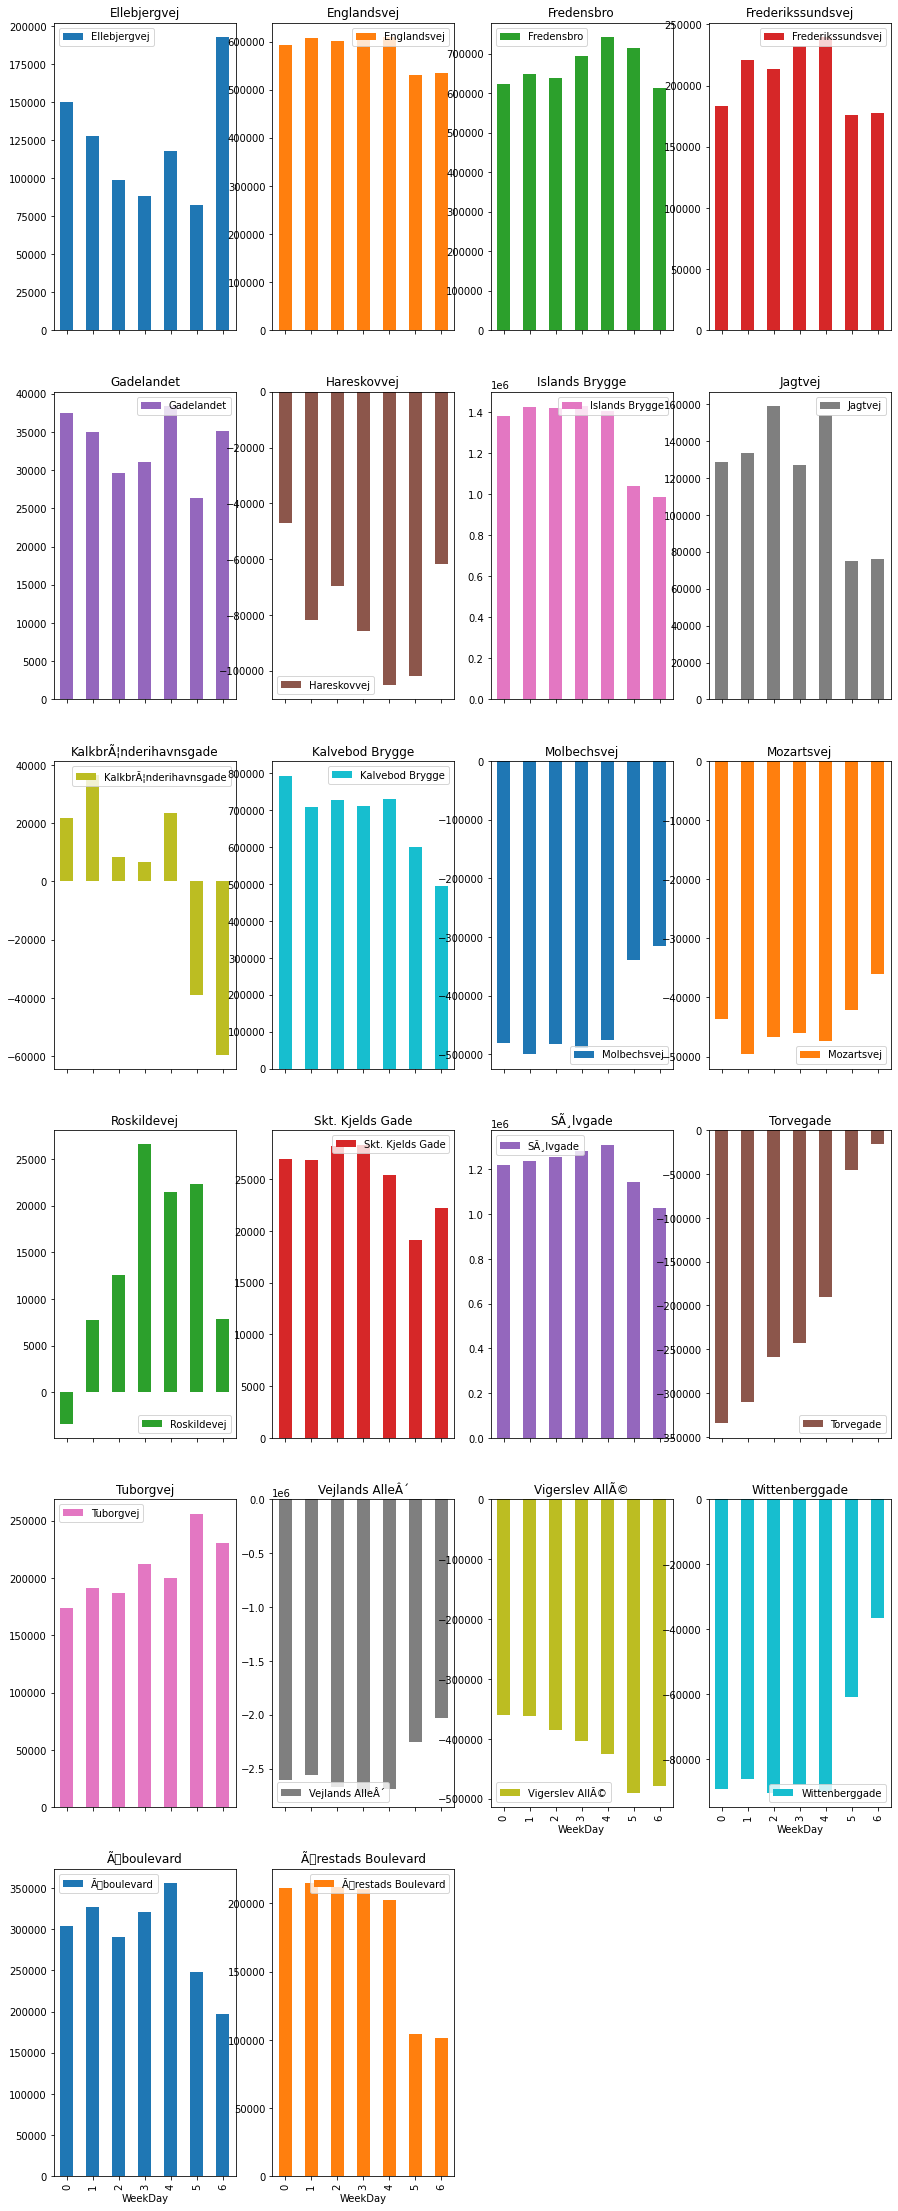

In [9]:
wd.plot(kind='bar', subplots=True, figsize=(15,60), layout=(9,4))